In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the 2018 Data ---
# Define the path to your 2018 CSV file
file_path_2018 = '/mnt/data_drive/kaggle/lending_club/by_year/accepted_2018.csv' # Adjust if your path is different

# Load the CSV.
# Since this is a yearly file, it might be small enough to load without nrows.
# However, LendingClub data can still have DtypeWarning issues, so low_memory=False is good practice.
# Also, consider specifying dtypes if you identified problematic columns during the full file processing.
print(f"Loading data from: {file_path_2018}...")
try:
    # If you know specific dtypes that cause issues or are very memory intensive, specify them.
    # For example, if 'emp_title' (column index depends on your full dataset) was problematic:
    # dtype_spec = {'emp_title': str}
    # df_2018 = pd.read_csv(file_path_2018, low_memory=False, dtype=dtype_spec)

    df_2018 = pd.read_csv(file_path_2018, low_memory=False)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"ERROR: File not found at {file_path_2018}. Please check the path.")
    # Stop execution or handle error appropriately
    df_2018 = pd.DataFrame() # Create an empty DataFrame to avoid further errors if file not found
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    df_2018 = pd.DataFrame()

if not df_2018.empty:
    # --- 2. Initial Data Inspection (for this specific year) ---
    print("\n--- Initial Data Inspection (accepted_2018.csv) ---")
    print(f"Shape of the dataset (rows, columns): {df_2018.shape}")

    print("\nFirst 5 rows:")
    print(df_2018.head())

    print("\nDataFrame Info (checking data types and non-null counts):")
    df_2018.info(verbose=True, show_counts=True)

    print("\nMissing values per column (top 20):")
    print(df_2018.isnull().sum().sort_values(ascending=False).head(20))

    print("\nDescriptive statistics for numerical features:")
    print(df_2018.describe())

    print("\nDescriptive statistics for object/categorical features:")
    print(df_2018.describe(include='object'))

    # --- 3. Define Your Target Variable ---
    # This step is crucial and depends on the 'loan_status' column.
    # You need to map different statuses to a binary outcome (e.g., 0 for Good Loan, 1 for Bad/Defaulted Loan).
    # Loans with 'Current' status or similar statuses where the outcome isn't final should typically be excluded
    # from a model predicting default.

    print("\n--- Defining Target Variable ('is_default') ---")
    if 'loan_status' in df_2018.columns:
        print("Unique values in 'loan_status':")
        print(df_2018['loan_status'].value_counts(dropna=False))

        # Define what constitutes a "default" or "bad loan"
        # This list might need adjustment based on your specific analysis goals and LendingClub's definitions
        default_statuses = ['Charged Off', 'Default',
                            'Does not meet the credit policy. Status:Charged Off', # Example, check your actual values
                            'Late (31-120 days)'] # Potentially include very late loans as defaults

        good_statuses = ['Fully Paid',
                         'Does not meet the credit policy. Status:Fully Paid'] # Example

        # Create the target variable
        # 0 for good loan, 1 for bad/defaulted loan
        # -1 for statuses to be filtered out (e.g., 'Current', 'In Grace Period', 'Issued', 'Late (16-30 days)' - if not considered default yet)
        def map_loan_status(status):
            if status in default_statuses:
                return 1
            elif status in good_statuses:
                return 0
            else:
                return -1 # To be filtered out

        df_2018['is_default'] = df_2018['loan_status'].apply(map_loan_status)

        # Filter out rows where the outcome is not yet determined or not relevant for default prediction
        df_model_data = df_2018[df_2018['is_default'] != -1].copy() # Use .copy() to avoid SettingWithCopyWarning

        if not df_model_data.empty:
            print(f"\nShape of data after filtering for defined outcomes: {df_model_data.shape}")
            print("\nDistribution of the target variable 'is_default':")
            print(df_model_data['is_default'].value_counts(normalize=True)) # normalize=True gives percentages
        else:
            print("No data remaining after filtering for defined loan outcomes. Check your status mapping.")
    else:
        print("ERROR: 'loan_status' column not found. Cannot define target variable.")
        df_model_data = pd.DataFrame() # Ensure df_model_data exists but is empty

    # --- 4. Data Cleaning and Preprocessing (Iterative Process) ---
    # This section will be extensive. Start with a few key areas.
    # Remember to use df_model_data from now on.

    if not df_model_data.empty:
        print("\n--- Starting Data Cleaning & Preprocessing (on df_model_data) ---")

        # Example: Handling missing values for a few columns (illustrative)
        # For high-cardinality categorical features like 'emp_title', filling with "Unknown" or a similar placeholder is common.
        if 'emp_title' in df_model_data.columns:
            df_model_data['emp_title'] = df_model_data['emp_title'].fillna('Unknown')

        # For numerical features, you might use median or mean.
        # Example: 'annual_inc'. First, check its distribution.
        if 'annual_inc' in df_model_data.columns:
            # df_model_data['annual_inc'].plot(kind='hist', bins=50, title='Annual Income Distribution')
            # plt.show()
            median_income = df_model_data['annual_inc'].median()
            df_model_data['annual_inc'] = df_model_data['annual_inc'].fillna(median_income)

        # Example: Converting date columns
        # 'issue_d' was already used for year splitting, but if you re-read, ensure it's datetime
        if 'issue_d' in df_model_data.columns and not pd.api.types.is_datetime64_any_dtype(df_model_data['issue_d']):
             df_model_data['issue_d_datetime'] = pd.to_datetime(df_model_data['issue_d'], format='%b-%Y', errors='coerce')

        if 'earliest_cr_line' in df_model_data.columns:
            df_model_data['earliest_cr_line_datetime'] = pd.to_datetime(df_model_data['earliest_cr_line'], format='%b-%Y', errors='coerce')
            # Example feature engineering: credit history length in days
            if 'issue_d_datetime' in df_model_data.columns and 'earliest_cr_line_datetime' in df_model_data.columns :
                df_model_data['credit_history_days'] = (df_model_data['issue_d_datetime'] - df_model_data['earliest_cr_line_datetime']).dt.days
                # Handle potential NaT from earlier coercion or if one date is missing
                df_model_data['credit_history_days'] = df_model_data['credit_history_days'].fillna(df_model_data['credit_history_days'].median())


        # Example: Cleaning and converting percentage string like 'int_rate' or 'revol_util'
        # Assuming 'int_rate' is like " 12.55%" and 'revol_util' is like "30.5%"
        def clean_percentage_string(value):
            if pd.isna(value):
                return np.nan
            if isinstance(value, (int, float)): # if already numeric
                return value
            return float(str(value).replace('%', '').strip())

        if 'int_rate' in df_model_data.columns:
            df_model_data['int_rate_cleaned'] = df_model_data['int_rate'].apply(clean_percentage_string)
            df_model_data['int_rate_cleaned'] = df_model_data['int_rate_cleaned'].fillna(df_model_data['int_rate_cleaned'].median())


        if 'revol_util' in df_model_data.columns:
            df_model_data['revol_util_cleaned'] = df_model_data['revol_util'].apply(clean_percentage_string)
            df_model_data['revol_util_cleaned'] = df_model_data['revol_util_cleaned'].fillna(df_model_data['revol_util_cleaned'].median())

        print("\nSample of df_model_data after some initial cleaning steps:")
        print(df_model_data[['emp_title', 'annual_inc', 'issue_d', 'earliest_cr_line', 'int_rate', 'revol_util', 'is_default']].head())
        if 'credit_history_days' in df_model_data.columns:
             print(df_model_data[['credit_history_days']].head())
        if 'int_rate_cleaned' in df_model_data.columns:
            print(df_model_data[['int_rate_cleaned']].head())
        if 'revol_util_cleaned' in df_model_data.columns:
            print(df_model_data[['revol_util_cleaned']].head())


        # --- Further Steps (to be detailed in subsequent cells/scripts) ---
        # 5. Identify and drop data leakage columns
        # 6. Feature Engineering (more advanced)
        # 7. Categorical Variable Encoding (OneHotEncoder or similar)
        # 8. Feature Selection
        # 9. Splitting data (X_train, X_test, y_train, y_test)
        # 10. Train a baseline ML model (e.g., Logistic Regression, Random Forest)
        # 11. Evaluate the model

        print("\nNext steps would involve more detailed cleaning, feature engineering, encoding, splitting, training, and evaluation.")

else:
    print("DataFrame df_2018 is empty. Cannot proceed with analysis.")

Loading data from: /mnt/data_drive/kaggle/lending_club/by_year/accepted_2018.csv...
Data loaded successfully!

--- Initial Data Inspection (accepted_2018.csv) ---
Shape of the dataset (rows, columns): (495242, 151)

First 5 rows:
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  130954621        NaN     5000.0       5000.0           5000.0   36 months   
1  130964697        NaN    15000.0      15000.0          15000.0   36 months   
2  130955326        NaN    11200.0      11200.0          11200.0   60 months   
3  130504052        NaN    25000.0      25000.0          25000.0   60 months   
4  130956066        NaN     3000.0       3000.0           3000.0   36 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     20.39       186.82     D        D4  ...                            NaN   
1      9.92       483.45     B        B2  ...                            NaN   
2     30.79       367.82     G        G1  ...    

In [2]:
if 'df_model_data' in locals() and not df_model_data.empty:
    print("Unique values in 'loan_status' from the filtered df_model_data:")
    print(df_model_data['loan_status'].value_counts(dropna=False))
elif 'df_2018' in locals() and not df_2018.empty:
    print("Unique values in 'loan_status' from the original df_2018 (before creating df_model_data):")
    print(df_2018['loan_status'].value_counts(dropna=False))
else:
    print("DataFrame df_2018 or df_model_data not found or is empty. Please ensure previous cells ran correctly.")

Unique values in 'loan_status' from the filtered df_model_data:
loan_status
Fully Paid            47444
Charged Off            8867
Late (31-120 days)     7221
Default                   7
Name: count, dtype: int64


In [3]:
if 'df_model_data' in locals() and not df_model_data.empty:
    # Define the statuses that will map to 1 (default/bad loan)
    # Based on your output, these are the relevant ones in df_model_data
    statuses_for_default = ['Charged Off', 'Default', 'Late (31-120 days)']

    # Create the 'is_default' column
    # If 'loan_status' is in statuses_for_default, then is_default = 1, otherwise 0
    df_model_data['is_default'] = df_model_data['loan_status'].apply(lambda x: 1 if x in statuses_for_default else 0)

    print("Created/updated 'is_default' column. Distribution:")
    print(df_model_data['is_default'].value_counts(normalize=True)) # normalize=True gives percentages
    print("\nValue counts:")
    print(df_model_data['is_default'].value_counts())

    # Verify that all loan_status values are now covered by 0 or 1 in 'is_default'
    print("\nCross-check 'loan_status' with 'is_default':")
    print(pd.crosstab(df_model_data['loan_status'], df_model_data['is_default']))
else:
    print("DataFrame df_model_data not found or is empty. Please ensure previous cells ran correctly and df_model_data was created.")

Created/updated 'is_default' column. Distribution:
is_default
0    0.746691
1    0.253309
Name: proportion, dtype: float64

Value counts:
is_default
0    47444
1    16095
Name: count, dtype: int64

Cross-check 'loan_status' with 'is_default':
is_default              0     1
loan_status                    
Charged Off             0  8867
Default                 0     7
Fully Paid          47444     0
Late (31-120 days)      0  7221


In [4]:
import pandas as pd # Ensure pandas is imported

# Ensure df_model_data exists from previous steps
if 'df_model_data' in locals() and not df_model_data.empty:

    # --- Step 3: Identify and Drop Data Leakage Columns ---
    print("--- Starting Step 3: Identify and Drop Data Leakage Columns ---")

    # Based on our review of 'example-1.csv' (your provided header)
    columns_to_drop = [
        # Obvious Data Leakage (Post-Origination)
        'funded_amnt', 'funded_amnt_inv',
        'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
        'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
        'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
        'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
        'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
        'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
        'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
        'hardship_loan_status', 'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
        'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date',
        'settlement_status', 'settlement_date', 'settlement_amount',
        'settlement_percentage', 'settlement_term',

        # Identifiers and Free Text (for initial model)
        'id', 'member_id',
        'emp_title', # High cardinality, drop for now
        'url', 'desc', 'title',
        'zip_code', # Drop for now, too granular
        'addr_state', # Drop for now, consider one-hot encoding later if desired

        # Target variable itself (and closely related if not already handled)
        'loan_status', # Already used to create 'is_default'

        # 'issue_d' was used for year splitting/filtering. If it's still in df_model_data
        # and you don't plan to use it for time-based feature engineering for origination prediction, drop it.
        # If 'issue_d_datetime' was created, drop the original 'issue_d' if it's still a string.
        # For now, let's assume 'issue_d' (original string version) should be dropped from features.
        'issue_d'
    ]

    # Find which of the columns_to_drop actually exist in df_model_data
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_model_data.columns]
    
    if existing_columns_to_drop:
        # Create a new DataFrame with the selected columns dropped
        # It's good practice to work on a copy if you want to keep the original df_model_data intact for other explorations
        df_model_data_cleaned = df_model_data.drop(columns=existing_columns_to_drop)
        
        print(f"\nDropped {len(existing_columns_to_drop)} columns.")
        print("Columns dropped:", existing_columns_to_drop)
        
        print(f"\nRemaining columns: {len(df_model_data_cleaned.columns)}")
        print("Sample of remaining columns:", df_model_data_cleaned.columns.tolist()[:20]) # Print first 20 remaining column names
        
        print("\nShape of df_model_data_cleaned:", df_model_data_cleaned.shape)
        
        # Display the first few rows of the cleaned data
        print("\nFirst 5 rows of df_model_data_cleaned:")
        print(df_model_data_cleaned.head())

        # OPTIONAL: You can reassign df_model_data to the cleaned version if you are done with the dropped columns
        # df_model_data = df_model_data_cleaned.copy()
        # print("\nReassigned df_model_data to the cleaned version.")

    else:
        print("No columns from the drop list were found in the DataFrame. df_model_data_cleaned is a copy of df_model_data.")
        df_model_data_cleaned = df_model_data.copy()

else:
    print("ERROR: DataFrame df_model_data not found or is empty. Please ensure previous cells (loading data, defining target) ran correctly.")

--- Starting Step 3: Identify and Drop Data Leakage Columns ---

Dropped 51 columns.
Columns dropped: ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'id', 'member_id', 'emp_title', 'ur

In [5]:
if 'df_model_data_cleaned' in locals() and not df_model_data_cleaned.empty:
    print("--- Starting Step 4: Systematic Missing Value Handling ---")
    missing_values = df_model_data_cleaned.isnull().sum()
    missing_percent = (df_model_data_cleaned.isnull().sum() / len(df_model_data_cleaned)) * 100

    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percent': missing_percent
    })

    # Display columns with missing values, sorted by percentage
    print("\nColumns with missing values (and their percentage):")
    print(missing_info[missing_info['Missing Values'] > 0].sort_values(by='Missing Percent', ascending=False))

    # Store this df_model_data_cleaned for the next step,
    # or create a new copy if you want to preserve this state.
    # For simplicity, we can work on df_model_data_cleaned directly for now.

else:
    print("df_model_data_cleaned is not available. Please ensure previous steps ran correctly.")

--- Starting Step 4: Systematic Missing Value Handling ---

Columns with missing values (and their percentage):
                                     Missing Values  Missing Percent
sec_app_mths_since_last_major_derog           60620        95.405971
verification_status_joint                     55538        87.407734
sec_app_revol_util                            55473        87.305434
dti_joint                                     55310        87.048899
sec_app_fico_range_low                        55310        87.048899
sec_app_fico_range_high                       55310        87.048899
sec_app_open_acc                              55310        87.048899
sec_app_inq_last_6mths                        55310        87.048899
sec_app_mort_acc                              55310        87.048899
sec_app_chargeoff_within_12_mths              55310        87.048899
annual_inc_joint                              55310        87.048899
sec_app_collections_12_mths_ex_med            55310        8

In [8]:
import pandas as pd
import numpy as np # Ensure numpy is imported for np.nan

# Ensure df_model_data_cleaned exists from the previous step
if 'df_model_data_cleaned' in locals() and not df_model_data_cleaned.empty:
    print("--- Starting Step 5 (Revised): Apply Imputation Strategies ---")
    # Create a new DataFrame for imputed data
    df_imputed = df_model_data_cleaned.copy()

    # --- Strategy 1: Drop columns with very high percentage of NaNs ---
    cols_to_drop_due_to_nan = [
        'sec_app_mths_since_last_major_derog', 'verification_status_joint', 'sec_app_revol_util',
        'dti_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_open_acc',
        'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_chargeoff_within_12_mths',
        'annual_inc_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line',
        'revol_bal_joint', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'mths_since_last_record'
    ]
    actual_cols_to_drop_nan = [col for col in cols_to_drop_due_to_nan if col in df_imputed.columns]
    if actual_cols_to_drop_nan:
        df_imputed.drop(columns=actual_cols_to_drop_nan, inplace=True) # drop can often safely use inplace on the DataFrame itself
        print(f"Dropped {len(actual_cols_to_drop_nan)} columns due to high NaN percentage: {actual_cols_to_drop_nan}")

    # --- Strategy 2: Impute "months since..." type columns with 0 ---
    cols_mths_since_to_impute_zero = [
        'mths_since_recent_bc_dlq', 'mths_since_last_major_derog',
        'mths_since_recent_revol_delinq', 'mths_since_last_delinq'
    ]
    for col in cols_mths_since_to_impute_zero:
        if col in df_imputed.columns:
            df_imputed[col] = df_imputed[col].fillna(0) # Assign back
            print(f"Imputed NaNs in '{col}' with 0.")

    # --- Strategy 3: Clean and Impute 'emp_length' ---
    if 'emp_length' in df_imputed.columns:
        def clean_emp_length(value):
            if pd.isna(value): return np.nan
            s_val = str(value)
            if '< 1 year' in s_val: return 0.5
            if '10+ years' in s_val: return 10.0
            num = ''.join(filter(str.isdigit, s_val))
            return float(num) if num else np.nan

        df_imputed['emp_length_numeric'] = df_imputed['emp_length'].apply(clean_emp_length)
        median_emp_length = df_imputed['emp_length_numeric'].median()
        df_imputed['emp_length_numeric'] = df_imputed['emp_length_numeric'].fillna(median_emp_length) # Assign back
        print(f"Cleaned 'emp_length' to 'emp_length_numeric' and imputed NaNs with median: {median_emp_length}")
        
        if 'emp_length' in df_imputed.columns:
             df_imputed.drop(columns=['emp_length'], inplace=True)
             print("Dropped original 'emp_length' column.")
    
    # --- Strategy 4: Impute remaining numerical columns with their median ---
    if 'revol_util' in df_imputed.columns and df_imputed['revol_util'].dtype == 'object':
        df_imputed['revol_util_cleaned'] = df_imputed['revol_util'].apply(
            lambda x: float(str(x).replace('%','').strip()) if pd.notna(x) else np.nan
        )
        if 'revol_util' in df_imputed.columns:
            df_imputed.drop(columns=['revol_util'], inplace=True)
            print("Cleaned 'revol_util' to 'revol_util_cleaned'.")
            
    numerical_cols_for_median_impute = [
        'il_util', 'mths_since_recent_inq', 'mo_sin_old_il_acct', 
        'mths_since_rcnt_il', 'bc_util', 'percent_bc_gt_75', 
        'bc_open_to_buy', 'mths_since_recent_bc', 'dti', 
        'revol_util_cleaned', 'all_util', 'avg_cur_bal', 'pct_tl_nvr_dlq',
        'credit_history_days', 'int_rate_cleaned'
    ]
    for col in numerical_cols_for_median_impute:
        if col in df_imputed.columns:
            if df_imputed[col].isnull().any():
                median_val = df_imputed[col].median()
                df_imputed[col] = df_imputed[col].fillna(median_val) # Assign back
                print(f"Imputed NaNs in '{col}' with median: {median_val}")

    # --- Strategy 5: Impute count-like numerical columns with 0 ---
    count_cols_to_impute_zero = ['num_tl_120dpd_2m']
    for col in count_cols_to_impute_zero:
        if col in df_imputed.columns:
            df_imputed[col] = df_imputed[col].fillna(0) # Assign back
            print(f"Imputed NaNs in '{col}' (count-like) with 0.")

    # --- Final Check for Missing Values ---
    print("\nMissing values after all imputation steps:")
    remaining_missing = df_imputed.isnull().sum()
    final_missing_report = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
    if final_missing_report.empty:
        print("No remaining missing values in feature columns! Excellent.")
    else:
        print("Warning: Some columns still have missing values:")
        print(final_missing_report)
    
    print(f"\nShape of df_imputed: {df_imputed.shape}")
    print("\nFirst 5 rows of df_imputed (sample of previously problematic/engineered columns):")
    sample_cols_to_display = [
        col for col in 
        ['emp_length_numeric', 'mths_since_last_delinq', 'il_util', 'dti', 'revol_util_cleaned', 'is_default'] 
        if col in df_imputed.columns
    ]
    if sample_cols_to_display:
        print(df_imputed[sample_cols_to_display].head())

else:
    print("ERROR: DataFrame df_model_data_cleaned not found or is empty. Please ensure previous steps ran correctly.")

--- Starting Step 5 (Revised): Apply Imputation Strategies ---
Dropped 17 columns due to high NaN percentage: ['sec_app_mths_since_last_major_derog', 'verification_status_joint', 'sec_app_revol_util', 'dti_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_chargeoff_within_12_mths', 'annual_inc_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'revol_bal_joint', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'mths_since_last_record']
Imputed NaNs in 'mths_since_recent_bc_dlq' with 0.
Imputed NaNs in 'mths_since_last_major_derog' with 0.
Imputed NaNs in 'mths_since_recent_revol_delinq' with 0.
Imputed NaNs in 'mths_since_last_delinq' with 0.
Cleaned 'emp_length' to 'emp_length_numeric' and imputed NaNs with median: 6.0
Dropped original 'emp_length' column.
Imputed NaNs in 'il_util' with median: 74.0
Imputed NaNs in 'mths_since_recent_inq' with median: 5.0
Imputed NaNs in 'mo_sin

In [9]:
if 'df_imputed' in locals() and not df_imputed.empty:
    # Check if 'revol_util_cleaned' exists, otherwise assume 'revol_util' is the one to fix
    col_to_fix = ''
    if 'revol_util_cleaned' in df_imputed.columns and df_imputed['revol_util_cleaned'].isnull().any():
        col_to_fix = 'revol_util_cleaned'
    elif 'revol_util' in df_imputed.columns and df_imputed['revol_util'].isnull().any():
        # This would imply 'revol_util' was numeric but still had NaNs,
        # or the cleaning to 'revol_util_cleaned' didn't happen as expected.
        # Let's assume if 'revol_util' is object, it needs cleaning first, then imputation.
        if df_imputed['revol_util'].dtype == 'object':
            print(f"Original 'revol_util' column is of type object and has NaNs. Attempting to clean and impute.")
            # Ensure cleaning happens first
            df_imputed['revol_util_cleaned_temp'] = df_imputed['revol_util'].apply(
                lambda x: float(str(x).replace('%','').strip()) if pd.notna(x) and '%' in str(x) else (float(x) if pd.notna(x) and str(x).replace('.','',1).isdigit() else np.nan)
            )
            # Drop original 'revol_util' if temp cleaned version is made
            if 'revol_util' in df_imputed.columns:
                df_imputed.drop(columns=['revol_util'], inplace=True)
            df_imputed.rename(columns={'revol_util_cleaned_temp': 'revol_util_cleaned'}, inplace=True)
            col_to_fix = 'revol_util_cleaned'
            print("Cleaned 'revol_util' to 'revol_util_cleaned'.")
        else: # It's numeric but has NaNs
            col_to_fix = 'revol_util'


    if col_to_fix and col_to_fix in df_imputed.columns and df_imputed[col_to_fix].isnull().any():
        print(f"--- Imputing remaining NaNs in '{col_to_fix}' ---")
        median_val = df_imputed[col_to_fix].median()
        df_imputed[col_to_fix] = df_imputed[col_to_fix].fillna(median_val) # Assign back
        print(f"Imputed NaNs in '{col_to_fix}' with its median: {median_val}")
    elif col_to_fix:
        print(f"No NaNs found in '{col_to_fix}' or column not found as expected.")
    else:
        print("Could not identify 'revol_util' or 'revol_util_cleaned' with NaNs for imputation.")


    # --- Final Check for Missing Values ---
    print("\nMissing values after attempting to fix revol_util*:")
    remaining_missing = df_imputed.isnull().sum()
    final_missing_report = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
    if final_missing_report.empty:
        print("No remaining missing values in feature columns! Excellent.")
    else:
        print("Warning: Some columns still have missing values:")
        print(final_missing_report)

    print(f"\nUpdated shape of df_imputed: {df_imputed.shape}")
else:
    print("ERROR: DataFrame df_imputed not found or is empty. Please ensure previous steps ran correctly.")

--- Imputing remaining NaNs in 'revol_util' ---
Imputed NaNs in 'revol_util' with its median: 37.0

Missing values after attempting to fix revol_util*:
No remaining missing values in feature columns! Excellent.

Updated shape of df_imputed: (63539, 89)


In [11]:
import pandas as pd # Ensure pandas is imported

if 'df_imputed' in locals() and not df_imputed.empty:
    print("--- Starting Step 7 (Revised): Categorical Variable Encoding ---")
    
    df_encoded = df_imputed.copy()

    # Drop original date string columns if their engineered numeric versions exist
    # and the originals are still objects.
    if 'earliest_cr_line' in df_encoded.columns and df_encoded['earliest_cr_line'].dtype == 'object':
        if 'credit_history_days' in df_encoded.columns: # Assuming this is the feature you want
            df_encoded.drop(columns=['earliest_cr_line'], inplace=True)
            print("Dropped original 'earliest_cr_line' (object type) column, will use engineered date features.")
        else:
            print("Warning: 'earliest_cr_line' is an object but 'credit_history_days' (or similar) not found. Consider feature engineering for 'earliest_cr_line'.")
            # If you still want to encode it (not usually recommended for raw date strings), leave it.
            # Otherwise, you might remove it from categorical_cols below if it has too many unique values.

    # If 'issue_d_datetime' was created and the original 'issue_d' (string) was somehow kept and is an object
    if 'issue_d' in df_encoded.columns and df_encoded['issue_d'].dtype == 'object':
        if 'issue_d_datetime' in df_encoded.columns or 'issue_year' in df_encoded.columns : # Assuming these are the features you want
            df_encoded.drop(columns=['issue_d'], inplace=True)
            print("Dropped original 'issue_d' (object type) column as datetime versions/features exist.")


    # 1. Identify categorical columns (typically 'object' dtype)
    categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nIdentified {len(categorical_cols)} categorical columns for one-hot encoding:")
    if categorical_cols:
        print(categorical_cols)

        # Optional: Review cardinality of these columns before encoding
        print("\nCardinality of identified categorical columns:")
        for col in categorical_cols:
            print(f"- {col}: {df_encoded[col].nunique()} unique values")

    else:
        print("No categorical columns found to encode.")

    # 2. Apply One-Hot Encoding using pandas.get_dummies()
    if categorical_cols:
        print("\nApplying one-hot encoding...")
        df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
        
        print("One-hot encoding complete.")
        print(f"\nNew shape of DataFrame after encoding: {df_encoded.shape}")
        print("\nSample of new columns (first few one-hot encoded columns):")
        
        original_cat_col_sample = categorical_cols[0] if categorical_cols else ''
        if original_cat_col_sample:
            # Try to find some of the newly created columns
            # Note: If drop_first=True, the first category won't have its own column.
            # We'll look for columns starting with the original name + "_"
            newly_encoded_cols_sample = [col for col in df_encoded.columns if col.startswith(original_cat_col_sample + "_")]
            if newly_encoded_cols_sample:
                 print(df_encoded[newly_encoded_cols_sample[:min(5, len(newly_encoded_cols_sample))]].head())
            else: # Fallback if no columns start with the pattern (e.g. if original_cat_col_sample had only 2 unique values and drop_first=True)
                 print(f"Could not find sample encoded columns for '{original_cat_col_sample}'. Showing general head:")
                 print(df_encoded.head())
        else:
            print(df_encoded.head())
    else:
        print("Skipping one-hot encoding as no suitable categorical columns were identified.")
    
    if 'is_default' in df_encoded.columns:
        print(f"\nTarget variable 'is_default' is present. Dtype: {df_encoded['is_default'].dtype}")
    else:
        print("\nWARNING: Target variable 'is_default' is missing from df_encoded!")

else:
    print("ERROR: DataFrame df_imputed not found or is empty. Please ensure previous steps ran correctly.")

--- Starting Step 7 (Revised): Categorical Variable Encoding ---
Dropped original 'earliest_cr_line' (object type) column, will use engineered date features.

Identified 8 categorical columns for one-hot encoding:
['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']

Cardinality of identified categorical columns:
- term: 2 unique values
- grade: 7 unique values
- sub_grade: 35 unique values
- home_ownership: 4 unique values
- verification_status: 3 unique values
- purpose: 13 unique values
- initial_list_status: 2 unique values
- application_type: 2 unique values

Applying one-hot encoding...
One-hot encoding complete.

New shape of DataFrame after encoding: (63539, 140)

Sample of new columns (first few one-hot encoded columns):
    term_ 60 months
4             False
16            False
23            False
24             True
38            False

Target variable 'is_default' is present. Dtype: int64


In [12]:
if 'df_encoded' in locals() and not df_encoded.empty:
    print("--- Starting Step 8: Splitting Features (X) and Target (y) ---")

    # The target variable is 'is_default'
    target_column = 'is_default'

    if target_column in df_encoded.columns:
        X = df_encoded.drop(columns=[target_column])
        y = df_encoded[target_column]

        print(f"Features (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")

        print("\nFirst 5 rows of X (features):")
        print(X.head())

        print("\nFirst 5 values of y (target):")
        print(y.head())

        print("\nData types in X (checking for non-numeric after encoding):")
        # All columns in X should now be numeric (int or float)
        non_numeric_cols_in_X = X.select_dtypes(exclude=[np.number]).columns
        if len(non_numeric_cols_in_X) == 0:
            print("All feature columns in X are numeric. Good!")
        else:
            print(f"Warning: Non-numeric columns found in X: {non_numeric_cols_in_X.tolist()}")
            print(X[non_numeric_cols_in_X].info())

    else:
        print(f"ERROR: Target column '{target_column}' not found in df_encoded!")
        # Assign empty X and y to prevent errors in subsequent cells if target is missing
        X = pd.DataFrame()
        y = pd.Series(dtype='int')


else:
    print("ERROR: DataFrame df_encoded not found or is empty. Please ensure previous steps ran correctly.")

--- Starting Step 8: Splitting Features (X) and Target (y) ---
Features (X) shape: (63539, 139)
Target (y) shape: (63539,)

First 5 rows of X (features):
    loan_amnt  int_rate  installment  annual_inc    dti  delinq_2yrs  \
4      3000.0      7.34        93.10     52000.0   0.58          0.0   
16     5000.0     11.98       166.03     55000.0  14.18          0.0   
23     7000.0     11.98       232.44     40000.0  20.25          0.0   
24    20300.0     17.47       509.66     55000.0  26.63          0.0   
38    30000.0     21.85      1143.39     57000.0  27.58          0.0   

    fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  \
4            760.0            764.0             0.0                    26.0   
16           675.0            679.0             0.0                    74.0   
23           695.0            699.0             0.0                    60.0   
24           705.0            709.0             0.0                     0.0   
38           680.0

In [13]:
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported for np.number

if 'X' in locals() and not X.empty:
    print("--- Starting Step 8.1: Drop Remaining Datetime Columns from X ---")

    datetime_cols_to_drop_from_X = X.select_dtypes(include=['datetime64[ns]']).columns.tolist()

    if datetime_cols_to_drop_from_X:
        X = X.drop(columns=datetime_cols_to_drop_from_X)
        print(f"Dropped datetime columns from X: {datetime_cols_to_drop_from_X}")
        print(f"New shape of X: {X.shape}")
    else:
        print("No datetime columns found in X to drop.")

    print("\nRe-checking data types in X:")
    non_numeric_cols_in_X = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols_in_X) == 0:
        print("All feature columns in X are now numeric (or boolean, which is fine). Good!")
    else:
        print(f"Warning: Non-numeric columns still found in X: {non_numeric_cols_in_X.tolist()}")
        print(X[non_numeric_cols_in_X].info())
        print("Review these columns. Boolean columns are acceptable for scikit-learn.")

else:
    print("ERROR: DataFrame X not found or is empty. Please ensure the previous step (Step 8) ran correctly.")

--- Starting Step 8.1: Drop Remaining Datetime Columns from X ---
Dropped datetime columns from X: ['issue_d_datetime', 'earliest_cr_line_datetime']
New shape of X: (63539, 137)

Re-checking data types in X:
<class 'pandas.core.frame.DataFrame'>
Index: 63539 entries, 4 to 495237
Data columns (total 60 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   term_ 60 months                      63539 non-null  bool 
 1   grade_B                              63539 non-null  bool 
 2   grade_C                              63539 non-null  bool 
 3   grade_D                              63539 non-null  bool 
 4   grade_E                              63539 non-null  bool 
 5   grade_F                              63539 non-null  bool 
 6   grade_G                              63539 non-null  bool 
 7   sub_grade_A2                         63539 non-null  bool 
 8   sub_grade_A3                         63539

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported if not already in this session/cell

# Ensure X and y exist from the previous step
if 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:
    print("--- Starting Step 9: Splitting Data into Training and Testing Sets ---")

    # Split the data: 80% for training, 20% for testing
    # random_state ensures reproducibility of the split
    # stratify=y is important for imbalanced datasets like this one to ensure
    # that both training and testing sets have a similar proportion of target classes.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Data splitting complete.")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    print("\nProportion of target class in y_train:")
    print(y_train.value_counts(normalize=True))

    print("\nProportion of target class in y_test:")
    print(y_test.value_counts(normalize=True))

else:
    print("ERROR: DataFrame X and/or Series y not found or are empty. Please ensure previous steps ran correctly.")

--- Starting Step 9: Splitting Data into Training and Testing Sets ---
Data splitting complete.
X_train shape: (50831, 137)
X_test shape: (12708, 137)
y_train shape: (50831,)
y_test shape: (12708,)

Proportion of target class in y_train:
is_default
0    0.74669
1    0.25331
Name: proportion, dtype: float64

Proportion of target class in y_test:
is_default
0    0.746695
1    0.253305
Name: proportion, dtype: float64


In [15]:
### GAME TIME ###

--- Starting Step 10: Train a Baseline Machine Learning Model (RandomForestClassifier) ---
Training RandomForestClassifier model...
Model training complete.

--- Model Evaluation ---
Making predictions on the test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      9489
           1       0.56      0.10      0.17      3219

    accuracy                           0.75     12708
   macro avg       0.66      0.54      0.51     12708
weighted avg       0.71      0.75      0.68     12708


Confusion Matrix:
[[9237  252]
 [2901  318]]


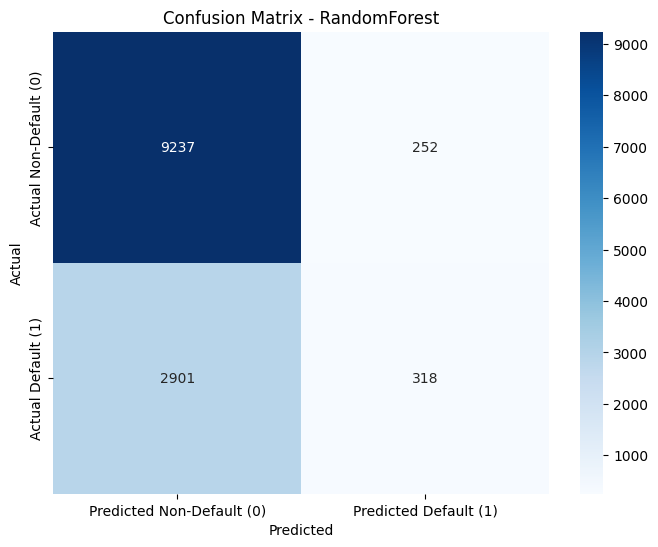


ROC AUC Score: 0.7207


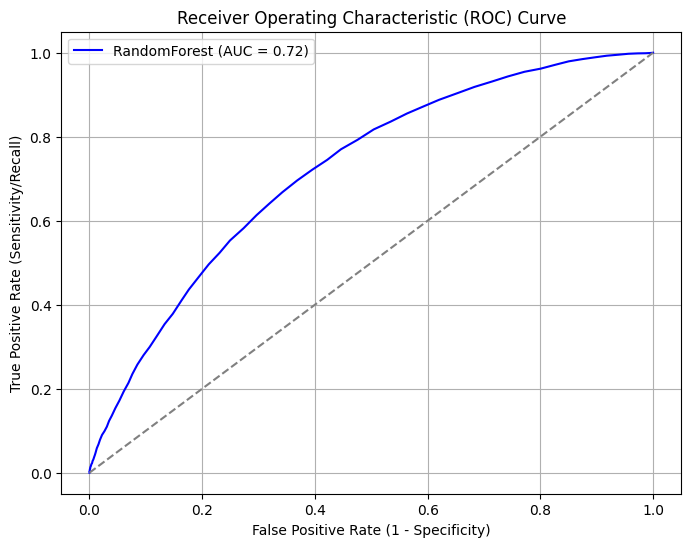

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Ensure X_train, X_test, y_train, y_test exist from the previous step
if 'X_train' in locals() and 'y_train' in locals() and \
   'X_test' in locals() and 'y_test' in locals() and \
   not X_train.empty and not y_train.empty:

    print("--- Starting Step 10: Train a Baseline Machine Learning Model (RandomForestClassifier) ---")

    # Initialize the RandomForestClassifier
    # n_estimators: number of trees in the forest
    # random_state: for reproducibility
    # class_weight='balanced': adjusts weights inversely proportional to class frequencies
    # n_jobs=-1: use all available processor cores for training (can speed it up)
    model_rf = RandomForestClassifier(n_estimators=100,
                                      random_state=42,
                                      class_weight='balanced',
                                      n_jobs=-1)

    print("Training RandomForestClassifier model...")
    model_rf.fit(X_train, y_train)
    print("Model training complete.")

    # --- Evaluate the Model ---
    print("\n--- Model Evaluation ---")

    # Predictions on the test set
    print("Making predictions on the test set...")
    y_pred_rf = model_rf.predict(X_test)
    y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_rf)
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Non-Default (0)', 'Predicted Default (1)'], yticklabels=['Actual Non-Default (0)', 'Actual Default (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix - RandomForest')
    plt.show()

    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'RandomForest (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--') # Diagonal 50% line
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Training/testing data (X_train, y_train, X_test, y_test) not found or is empty. Please ensure previous steps ran correctly.")


--- Feature Importances ---


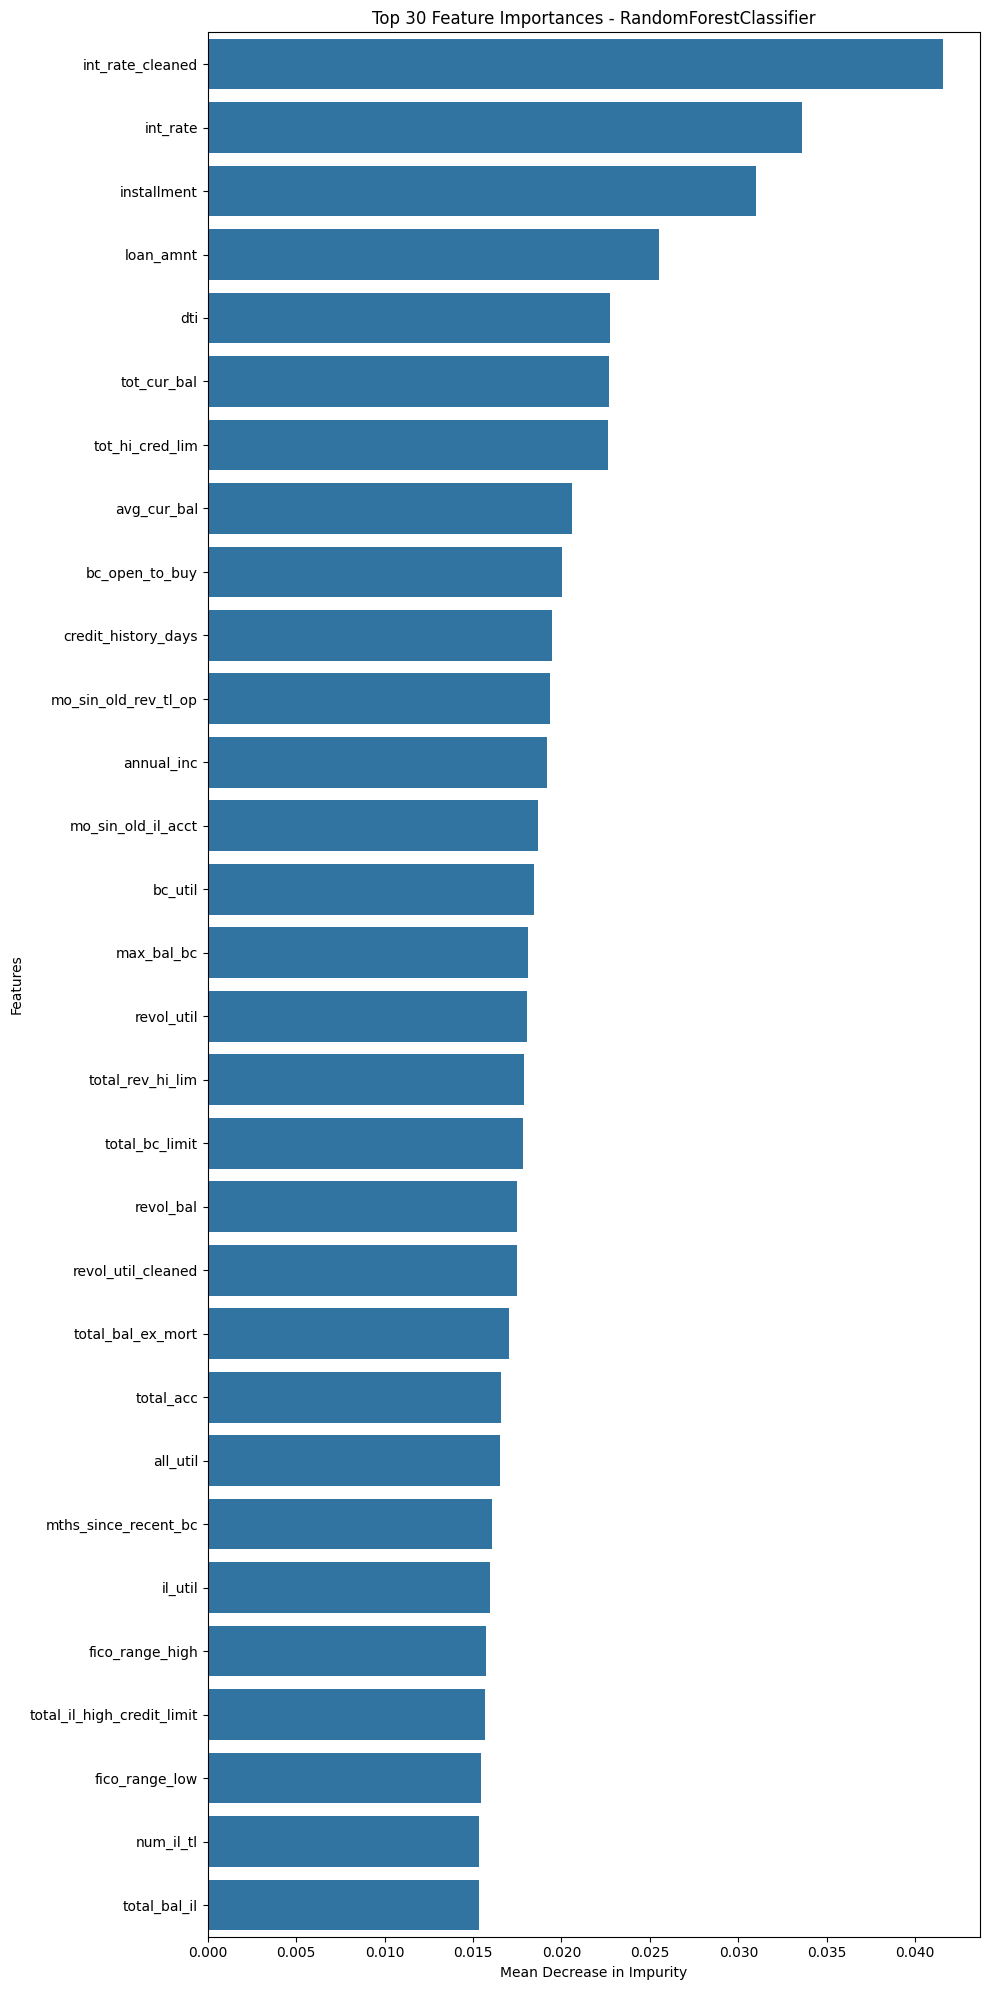


Top 50 features:
int_rate_cleaned              0.041585
int_rate                      0.033598
installment                   0.030980
loan_amnt                     0.025529
dti                           0.022752
tot_cur_bal                   0.022668
tot_hi_cred_lim               0.022638
avg_cur_bal                   0.020584
bc_open_to_buy                0.020005
credit_history_days           0.019474
mo_sin_old_rev_tl_op          0.019359
annual_inc                    0.019174
mo_sin_old_il_acct            0.018681
bc_util                       0.018451
max_bal_bc                    0.018133
revol_util                    0.018061
total_rev_hi_lim              0.017852
total_bc_limit                0.017806
revol_bal                     0.017496
revol_util_cleaned            0.017467
total_bal_ex_mort             0.017029
total_acc                     0.016592
all_util                      0.016528
mths_since_recent_bc          0.016073
il_util                       0.015983
fico_ra

In [18]:
if 'model_rf' in locals() and 'X_train' in locals():
    print("\n--- Feature Importances ---")
    importances = model_rf.feature_importances_
    feature_names = X_train.columns
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 20)) # Adjust figure size as needed
    sns.barplot(x=forest_importances[:30], y=forest_importances.index[:30]) # Plot top 30
    plt.title("Top 30 Feature Importances - RandomForestClassifier")
    plt.xlabel("Mean Decrease in Impurity")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    print("\nTop 50 features:")
    print(forest_importances.head(50))

In [19]:
# Assuming 'X' is your DataFrame of features before train_test_split
# and 'df_encoded' was the result of one-hot encoding.
# X = df_encoded.drop(columns=['is_default']).copy() # If you need to redefine X

if 'X' in locals() and not X.empty:
    print("\n--- Cleaning up redundant rate and util columns in X ---")
    columns_to_potentially_drop = []

    # Check for int_rate (original string/object) if int_rate_cleaned (numeric) exists
    if 'int_rate_cleaned' in X.columns and 'int_rate' in X.columns:
        if not pd.api.types.is_numeric_dtype(X['int_rate']) or X['int_rate'].dtype == 'object':
            columns_to_potentially_drop.append('int_rate')
        # Add more sophisticated checks if both are numeric but one is preferred

    # Check for revol_util (original string/object) if revol_util_cleaned (numeric) exists
    if 'revol_util_cleaned' in X.columns and 'revol_util' in X.columns:
        if not pd.api.types.is_numeric_dtype(X['revol_util']) or X['revol_util'].dtype == 'object':
            columns_to_potentially_drop.append('revol_util')

    if columns_to_potentially_drop:
        X.drop(columns=columns_to_potentially_drop, inplace=True)
        print(f"Dropped potentially redundant columns: {columns_to_potentially_drop}")
        print(f"New shape of X: {X.shape}")
    else:
        print("No obvious redundant rate/util columns found to drop based on dtype, or cleaned versions don't exist.")
        print("Ensure 'int_rate_cleaned' and 'revol_util_cleaned' are your final numeric features for these concepts.")

    # Ensure your target 'y' is still correctly defined from df_encoded before this X modification
    if 'df_encoded' in locals() and 'is_default' in df_encoded.columns:
        y = df_encoded['is_default'] # Re-align y if X was redefined
    else:
        print("Warning: df_encoded or 'is_default' not found, ensure y is correctly aligned with the modified X.")

else:
    print("DataFrame X not found or is empty for cleanup.")


--- Cleaning up redundant rate and util columns in X ---
No obvious redundant rate/util columns found to drop based on dtype, or cleaned versions don't exist.
Ensure 'int_rate_cleaned' and 'revol_util_cleaned' are your final numeric features for these concepts.


In [23]:
# Ensure X is your full feature DataFrame before train_test_split
# If you've already split, you'd apply these drops to X and then re-split,
# or apply to X_train and X_test consistently.
# For simplicity, let's assume you can redefine X from df_encoded if needed.

if 'df_encoded' in locals() and not df_encoded.empty and 'is_default' in df_encoded.columns:
    X = df_encoded.drop(columns=['is_default', 'issue_d_datetime', 'earliest_cr_line_datetime']) # Recreate X cleanly
    y = df_encoded['is_default']
    print("Recreated X and y to ensure clean state before this step.")
elif 'X' not in locals() or X.empty:
    print("ERROR: DataFrame X not found or is empty. Please ensure previous steps (up to one-hot encoding and X/y split) ran correctly.")
    # Stop execution or handle error
    raise NameError("DataFrame X is not defined or is empty.")


print("\n--- Step 11.1: Manually Verify and Drop Redundant Numeric Features ---")
columns_to_investigate = []
if 'int_rate' in X.columns and 'int_rate_cleaned' in X.columns:
    columns_to_investigate.extend(['int_rate', 'int_rate_cleaned'])
if 'revol_util' in X.columns and 'revol_util_cleaned' in X.columns:
    columns_to_investigate.extend(['revol_util', 'revol_util_cleaned'])

if columns_to_investigate:
    print("\nInspecting potentially redundant columns:")
    for col in columns_to_investigate:
        print(f"\nColumn: {col}")
        print(f"Dtype: {X[col].dtype}")
        print("Sample values:")
        print(X[col].head())
        print(f"Is numeric: {pd.api.types.is_numeric_dtype(X[col])}")
        print(f"Number of NaNs: {X[col].isnull().sum()}")

    # **YOUR DECISION POINT HERE**
    # Based on the inspection, decide which columns to drop.
    # For example, if 'int_rate_cleaned' is your final version, drop 'int_rate'.
    # If 'revol_util_cleaned' is your final version, drop 'revol_util'.

    cols_to_manually_drop = []
    # Example decisions (ADAPT THIS BASED ON YOUR INSPECTION):
    if 'int_rate_cleaned' in X.columns and 'int_rate' in X.columns:
        # Assuming int_rate_cleaned is the one to keep
        print("\nDecision: Keeping 'int_rate_cleaned', dropping 'int_rate'.")
        cols_to_manually_drop.append('int_rate')

    if 'revol_util_cleaned' in X.columns and 'revol_util' in X.columns:
        # Assuming revol_util_cleaned is the one to keep
        print("\nDecision: Keeping 'revol_util_cleaned', dropping 'revol_util'.")
        cols_to_manually_drop.append('revol_util')

    if cols_to_manually_drop:
        # Ensure columns actually exist before trying to drop
        actual_cols_to_drop = [col for col in cols_to_manually_drop if col in X.columns]
        if actual_cols_to_drop:
            X.drop(columns=actual_cols_to_drop, inplace=True)
            print(f"\nManually dropped columns: {actual_cols_to_drop}")
            print(f"New shape of X: {X.shape}")
        else:
            print("\nNo columns specified for manual drop were found in X.")
    else:
        print("\nNo manual drops specified. Ensure you have only one version of rate/util features.")

else:
    print("\nNo pairs like 'int_rate'/'int_rate_cleaned' or 'revol_util'/'revol_util_cleaned' found in X. This is good.")
    print("Proceeding with current features in X.")

# Verify X again
print("\nFinal check of X columns (first 10):")
print(X.columns.tolist()[:10])
print(f"Total columns in X: {len(X.columns)}")

# --- ADD THIS PART TO SAVE X and y WITH VERSIONING ---
if 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:
    print("\n--- Saving processed X and y with versioning ---")
    
    # Define your version string
    version_tag = "v1.0.0" # You can change this for future versions

    # Define file paths for saving
    # Make sure the directory exists or create it
    output_data_directory = '/mnt/data_drive/kaggle/lending_club/processed_data/' # Adjust as needed
    import os
    os.makedirs(output_data_directory, exist_ok=True)

    # Construct filenames with the version tag
    x_filename = f'X_processed_2018.{version_tag}.parquet'
    y_filename = f'y_target_2018.{version_tag}.csv'

    x_filepath_parquet = os.path.join(output_data_directory, x_filename)
    y_filepath_csv = os.path.join(output_data_directory, y_filename)

    try:
        # Save X as Parquet
        # Ensure you have 'pyarrow' installed: pip install pyarrow
        X.to_parquet(x_filepath_parquet, index=False)
        print(f"Saved processed features X to: {x_filepath_parquet}")

        # Save y as CSV
        y.to_csv(y_filepath_csv, index=False, header=['is_default']) # Add header for clarity
        print(f"Saved target y to: {y_filepath_csv}")
        
        print("X and y successfully saved with versioning!")

    except Exception as e:
        print(f"Error saving data: {e}")
        print("Ensure you have 'pyarrow' installed if using Parquet: pip install pyarrow")

else:
    print("ERROR: DataFrame X or Series y not found or empty. Cannot save.")

# --- END OF ADDED SAVE CODE ---

Recreated X and y to ensure clean state before this step.

--- Step 11.1: Manually Verify and Drop Redundant Numeric Features ---

Inspecting potentially redundant columns:

Column: int_rate
Dtype: float64
Sample values:
4      7.34
16    11.98
23    11.98
24    17.47
38    21.85
Name: int_rate, dtype: float64
Is numeric: True
Number of NaNs: 0

Column: int_rate_cleaned
Dtype: float64
Sample values:
4      7.34
16    11.98
23    11.98
24    17.47
38    21.85
Name: int_rate_cleaned, dtype: float64
Is numeric: True
Number of NaNs: 0

Column: revol_util
Dtype: float64
Sample values:
4      0.5
16    33.9
23    36.0
24    70.9
38    53.2
Name: revol_util, dtype: float64
Is numeric: True
Number of NaNs: 0

Column: revol_util_cleaned
Dtype: float64
Sample values:
4      0.5
16    33.9
23    36.0
24    70.9
38    53.2
Name: revol_util_cleaned, dtype: float64
Is numeric: True
Number of NaNs: 0

Decision: Keeping 'int_rate_cleaned', dropping 'int_rate'.

Decision: Keeping 'revol_util_cleaned', 

--- Starting Step 11.2: Re-run Full Pipeline with Final Cleaned X ---

1. Splitting data into Training and Testing sets...
Data splitting complete.
X_train shape: (50831, 135)
X_test shape: (12708, 135)
y_train shape: (50831,)
y_test shape: (12708,)
Proportion of target class in y_train:
is_default
0    0.74669
1    0.25331
Name: proportion, dtype: float64

Proportion of target class in y_test:
is_default
0    0.746695
1    0.253305
Name: proportion, dtype: float64

2. Training RandomForestClassifier model...
Model training complete.

--- Model Evaluation (with final cleaned features) ---
Making predictions on the test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      9489
           1       0.60      0.10      0.17      3219

    accuracy                           0.76     12708
   macro avg       0.68      0.54      0.51     12708
weighted avg       0.72      0.76      0.68     12708


Confusion Matr

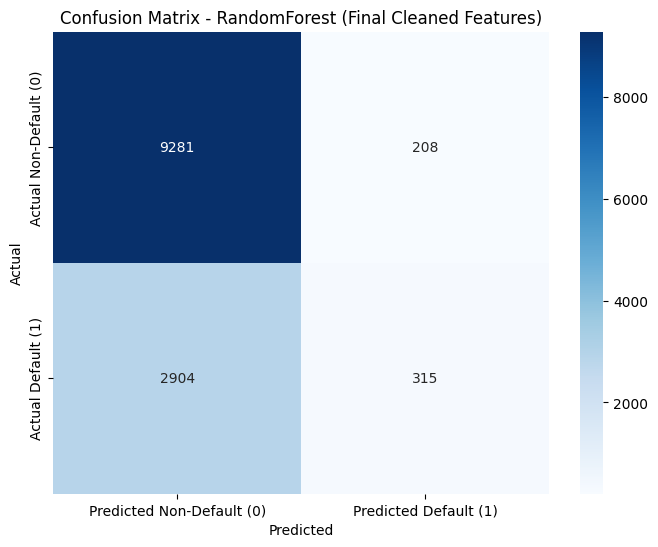


ROC AUC Score: 0.7246


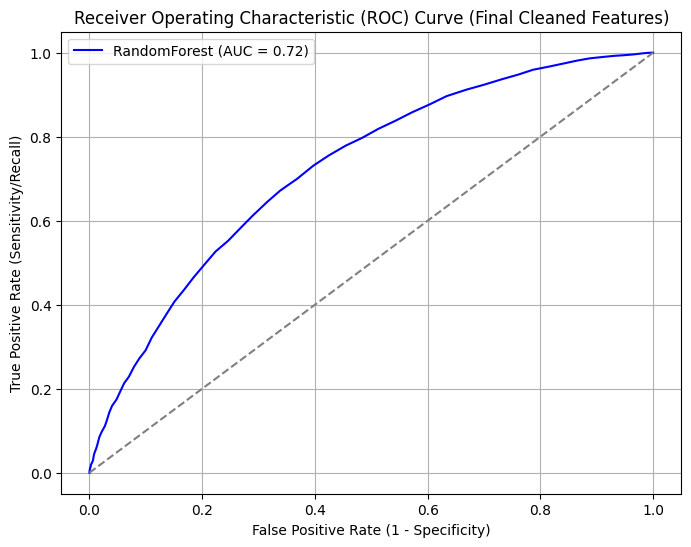


--- Feature Importances (Final Cleaned Features) ---


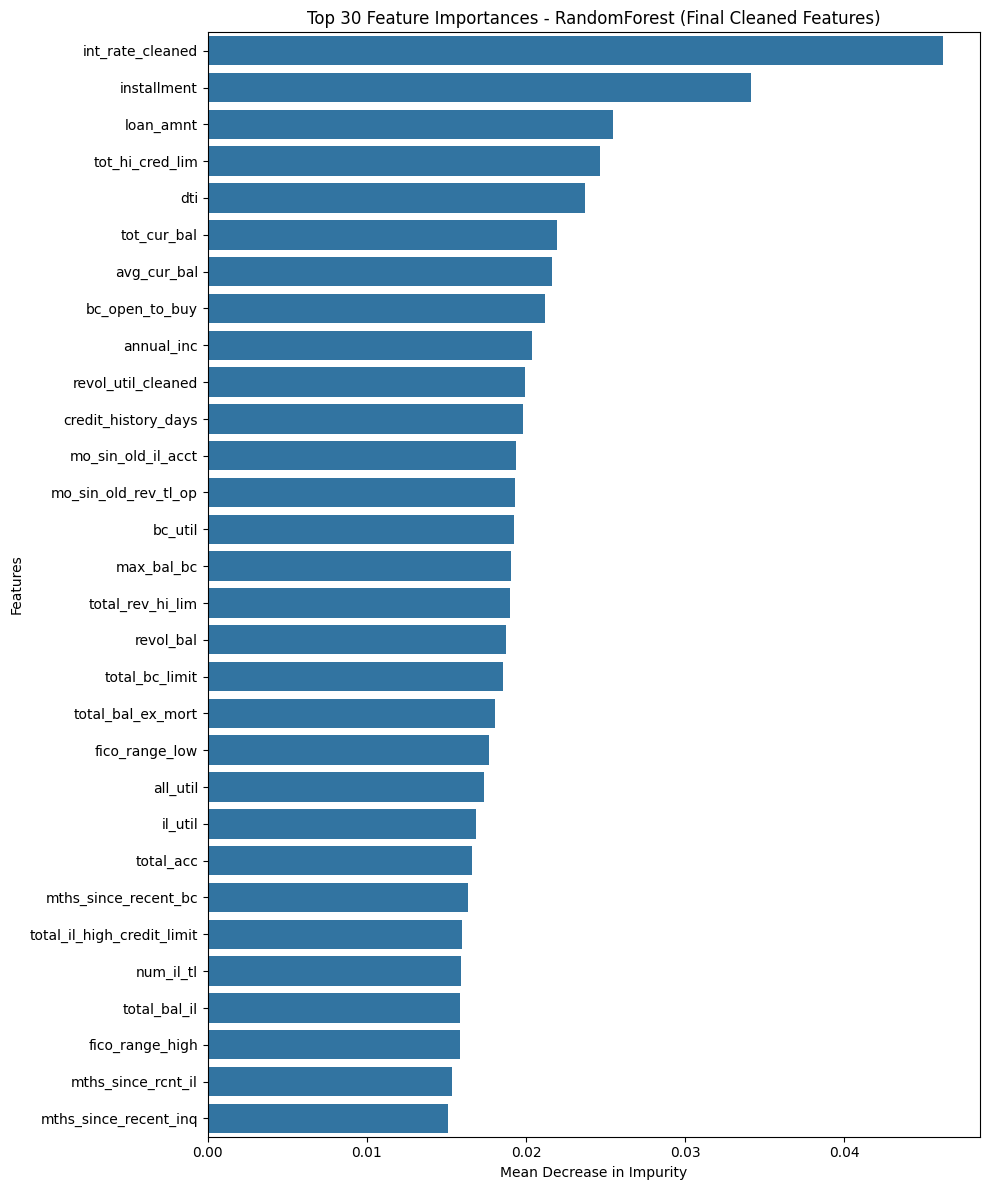


Top 30 features:
int_rate_cleaned              0.046228
installment                   0.034120
loan_amnt                     0.025493
tot_hi_cred_lim               0.024674
dti                           0.023724
tot_cur_bal                   0.021976
avg_cur_bal                   0.021620
bc_open_to_buy                0.021194
annual_inc                    0.020364
revol_util_cleaned            0.019916
credit_history_days           0.019804
mo_sin_old_il_acct            0.019359
mo_sin_old_rev_tl_op          0.019332
bc_util                       0.019235
max_bal_bc                    0.019087
total_rev_hi_lim              0.018994
revol_bal                     0.018723
total_bc_limit                0.018583
total_bal_ex_mort             0.018080
fico_range_low                0.017668
all_util                      0.017367
il_util                       0.016858
total_acc                     0.016634
mths_since_recent_bc          0.016336
total_il_high_credit_limit    0.015989
num_il_

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported

# Ensure X and y exist from the previous cell (either in memory or loaded from saved files)
if 'X' in locals() and 'y' in locals() and not X.empty and not y.empty:
    print("--- Starting Step 11.2: Re-run Full Pipeline with Final Cleaned X ---")

    # 1. Re-run Train-Test Split
    print("\n1. Splitting data into Training and Testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Data splitting complete.")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("Proportion of target class in y_train:")
    print(y_train.value_counts(normalize=True))
    print("\nProportion of target class in y_test:")
    print(y_test.value_counts(normalize=True))

    # 2. Re-train RandomForestClassifier Model
    print("\n2. Training RandomForestClassifier model...")
    # You can adjust n_estimators later, 100 is a good starting point
    model_rf = RandomForestClassifier(n_estimators=100,
                                      random_state=42,
                                      class_weight='balanced',
                                      n_jobs=-1) # Use all available cores
    model_rf.fit(X_train, y_train)
    print("Model training complete.")

    # 3. Re-evaluate the Model
    print("\n--- Model Evaluation (with final cleaned features) ---")
    print("Making predictions on the test set...")
    y_pred_rf = model_rf.predict(X_test)
    y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_rf)
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Non-Default (0)', 'Predicted Default (1)'], 
                yticklabels=['Actual Non-Default (0)', 'Actual Default (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix - RandomForest (Final Cleaned Features)')
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'RandomForest (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--') # Diagonal 50% line
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Final Cleaned Features)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Re-calculate and Display Feature Importances
    print("\n--- Feature Importances (Final Cleaned Features) ---")
    importances = model_rf.feature_importances_
    # Use X.columns because X_train might not be available if loading data from file in a new session
    # However, if this cell runs immediately after X_train is defined, X_train.columns is fine.
    # For robustness if this cell is run independently after loading X:
    feature_names = X.columns 
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 12)) # Adjust figure size as needed
    top_n_features = 30 # You can adjust how many top features to plot
    sns.barplot(x=forest_importances[:top_n_features], y=forest_importances.index[:top_n_features])
    plt.title(f"Top {top_n_features} Feature Importances - RandomForest (Final Cleaned Features)")
    plt.xlabel("Mean Decrease in Impurity")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n_features} features:")
    print(forest_importances.head(top_n_features))

else:
    print("ERROR: DataFrame X and/or Series y not found or are empty. Please ensure X is your fully cleaned feature set and y is your target variable.")